# LSTM Forecasting Model - Accuracy Metrics Analysis

- **MAE** (Mean Absolute Error)
- **MSE** (Mean Squared Error)
- **RMSE** (Root Mean Squared Error)
- **R²** (R-squared Score)

In [12]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Add backend to path
sys.path.insert(0, os.path.join(os.getcwd(), 'backend'))
from data.generate_historical_data import load_historical_data

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [17]:
# Load historical data
data_file = './backend/data/historical_tickets.csv'

if not os.path.exists(data_file):
    print("Data not found. Run: python backend/train_forecast_model.py")
else:
    df = load_historical_data(data_file)
    print(f"Loaded {len(df)} records")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    display(df.head())
    display(df['ticket_count'].describe())

Loaded 4321 records
   Date range: 2025-05-07 11:36:40.875388 to 2025-11-03 11:36:40.875388


,timestamp,ticket_count,hour,day_of_week,day_of_month,month,is_business_hours,is_weekend
0,2025-05-07 11:36:40.875388,6,11,2,7,5,1,0
1,2025-05-07 12:36:40.875388,6,12,2,7,5,1,0
2,2025-05-07 13:36:40.875388,6,13,2,7,5,1,0
3,2025-05-07 14:36:40.875388,7,14,2,7,5,1,0
4,2025-05-07 15:36:40.875388,6,15,2,7,5,1,0


count    4321.000000
mean        2.698912
std         2.440746
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        13.000000
Name: ticket_count, dtype: float64

In [18]:
# Load trained model
from tensorflow.keras.models import load_model

model_path = './backend/models/lstm_forecast.h5'
scaler_path = './backend/models/lstm_forecast_scaler.pkl'

if not os.path.exists(model_path):
    print("Model not found. Train the model first.")
else:
    model = load_model(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print("Model loaded successfully")
    model.summary()

Model loaded successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,903 (124.62 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:
# Prepare test data
def prepare_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Normalize and split
ticket_counts = df['ticket_count'].values.reshape(-1, 1)
scaled_data = scaler.transform(ticket_counts)

train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size:]

X_test, y_test = prepare_sequences(test_data, 24)
print(f"Test sequences prepared: {len(X_test)}")

Test sequences prepared: 841


In [16]:
# Generate predictions
print("Making predictions...")
y_pred_scaled = model.predict(X_test, verbose=0)

# Convert back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = np.maximum(0, y_pred)  # Ensure non-negative

print(f"Generated {len(y_pred)} predictions")

Making predictions...
Generated 841 predictions


## Calculate 4 Key Accuracy Metrics

In [ ]:
# Calculate all 4 metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

# Display results
print("\n" + "="*70)
print("  MODEL ACCURACY METRICS")
print("="*70)
print(f"\n  1. MAE  (Mean Absolute Error)      : {mae:.2f} tickets")
print(f"     → Average prediction error\n")

print(f"  2. MSE  (Mean Squared Error)        : {mse:.2f} tickets²")
print(f"     → Emphasizes larger errors\n")

print(f"  3. RMSE (Root Mean Squared Error)   : {rmse:.2f} tickets")
print(f"     → Typical prediction error\n")

print(f"  4. R²   (R-squared Score)           : {r2:.4f}")
print(f"     → {r2*100:.2f}% of variance explained")

print("\n" + "="*70)

# Quality assessment
print("\nModel Quality Assessment:")
if r2 > 0.8:
    print("   EXCELLENT - Model performs very well!")
elif r2 > 0.6:
    print("   GOOD - Model performs well")
elif r2 > 0.4:
    print("   MODERATE - Room for improvement")
else:
    print("   POOR - Consider retraining")

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Value': [mae, mse, rmse, r2],
    'Unit': ['tickets', 'tickets²', 'tickets', 'score']
})

print("\nMetrics Summary Table:")
display(metrics_df)


 MODEL ACCURACY METRICS

  1. MAE  (Mean Absolute Error)      : 0.62 tickets
     → Average prediction error

  2. MSE  (Mean Squared Error)        : 0.90 tickets²
     → Emphasizes larger errors

  3. RMSE (Root Mean Squared Error)   : 0.95 tickets
     → Typical prediction error

  4. R²   (R-squared Score)           : 0.8584
     → 85.84% of variance explained


Model Quality Assessment:
EXCELLENT - Model performs very well!

Metrics Summary Table:


,Metric,Value,Unit
0,MAE,0.619184,tickets
1,MSE,0.897749,tickets²
2,RMSE,0.947496,tickets
3,R²,0.858422,score


## Visualizations

### Visualization 1: Time Series - Predicted vs Actual

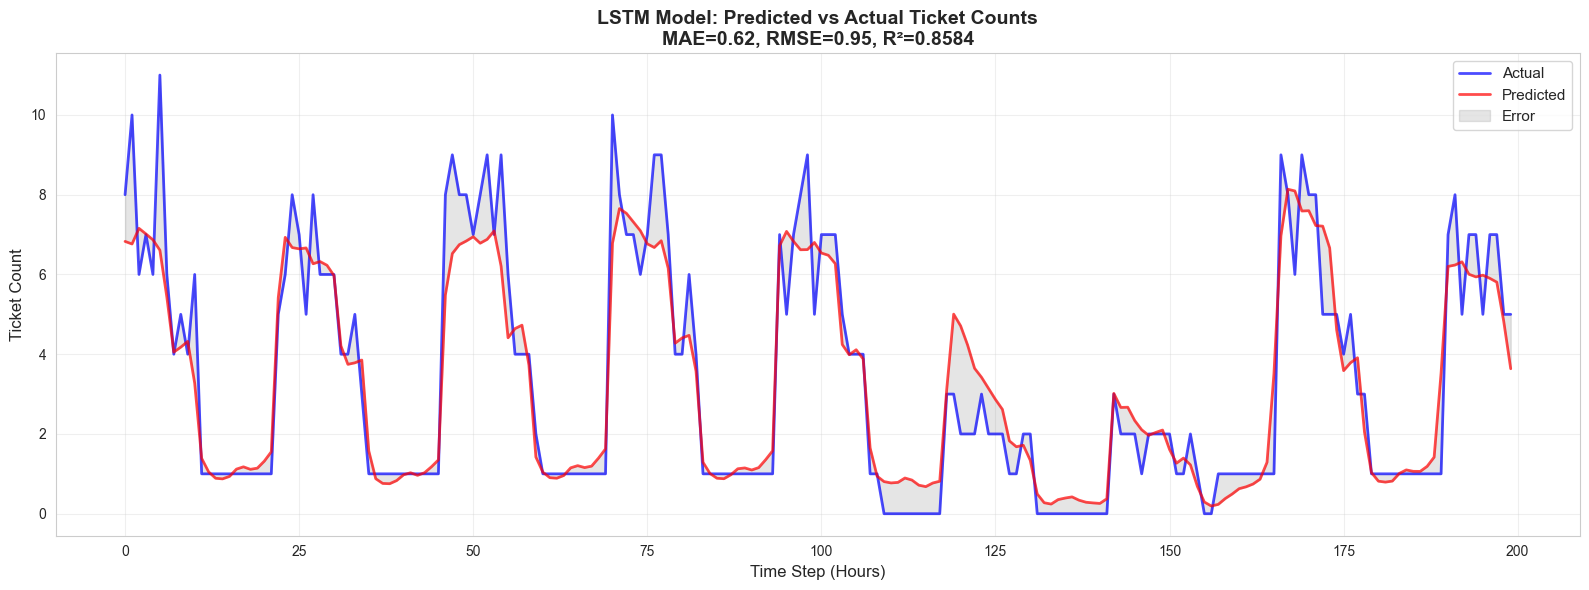

Blue line = Actual values
Red line = Model predictions
Gray area = Prediction error


In [8]:
# Time series plot
plt.figure(figsize=(16, 6))

n_samples = min(200, len(y_pred))
time_indices = range(n_samples)

plt.plot(time_indices, y_actual[:n_samples], 
         label='Actual', color='blue', linewidth=2, alpha=0.7)
plt.plot(time_indices, y_pred[:n_samples], 
         label='Predicted', color='red', linewidth=2, alpha=0.7)
plt.fill_between(time_indices, 
                 y_actual[:n_samples].flatten(), 
                 y_pred[:n_samples].flatten(), 
                 alpha=0.2, color='gray', label='Error')

plt.xlabel('Time Step (Hours)', fontsize=12)
plt.ylabel('Ticket Count', fontsize=12)
plt.title(f'LSTM Model: Predicted vs Actual Ticket Counts\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Blue line = Actual values")
print("Red line = Model predictions")
print("Gray area = Prediction error")

### Visualization 2: Scatter Plot - Prediction Accuracy

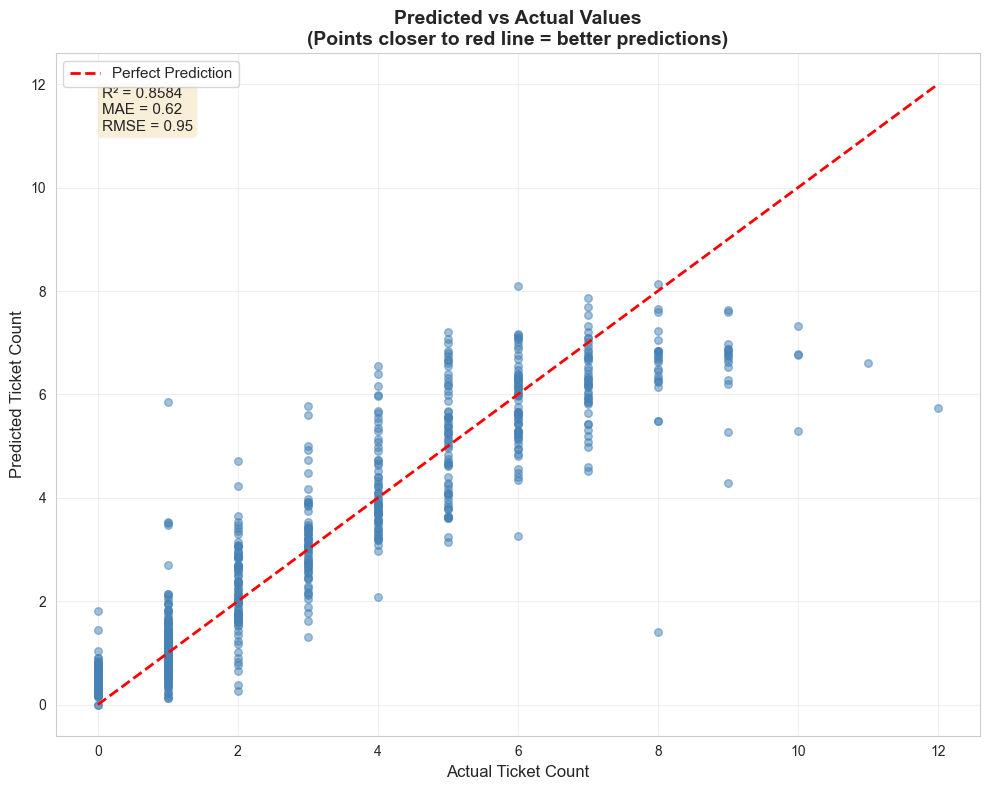

Points near red line = accurate predictions
Points above line = over-prediction
Points below line = under-prediction


In [9]:
# Scatter plot
plt.figure(figsize=(10, 8))

plt.scatter(y_actual, y_pred, alpha=0.5, s=30, color='steelblue')
plt.plot([y_actual.min(), y_actual.max()], 
         [y_actual.min(), y_actual.max()], 
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Ticket Count', fontsize=12)
plt.ylabel('Predicted Ticket Count', fontsize=12)
plt.title('Predicted vs Actual Values\n(Points closer to red line = better predictions)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add metrics annotation
textstr = f'R² = {r2:.4f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}'
plt.text(0.05, 0.95, textstr, 
         transform=plt.gca().transAxes, 
         fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("Points near red line = accurate predictions")
print("Points above line = over-prediction")
print("Points below line = under-prediction")

### Visualization 3: Error Distribution

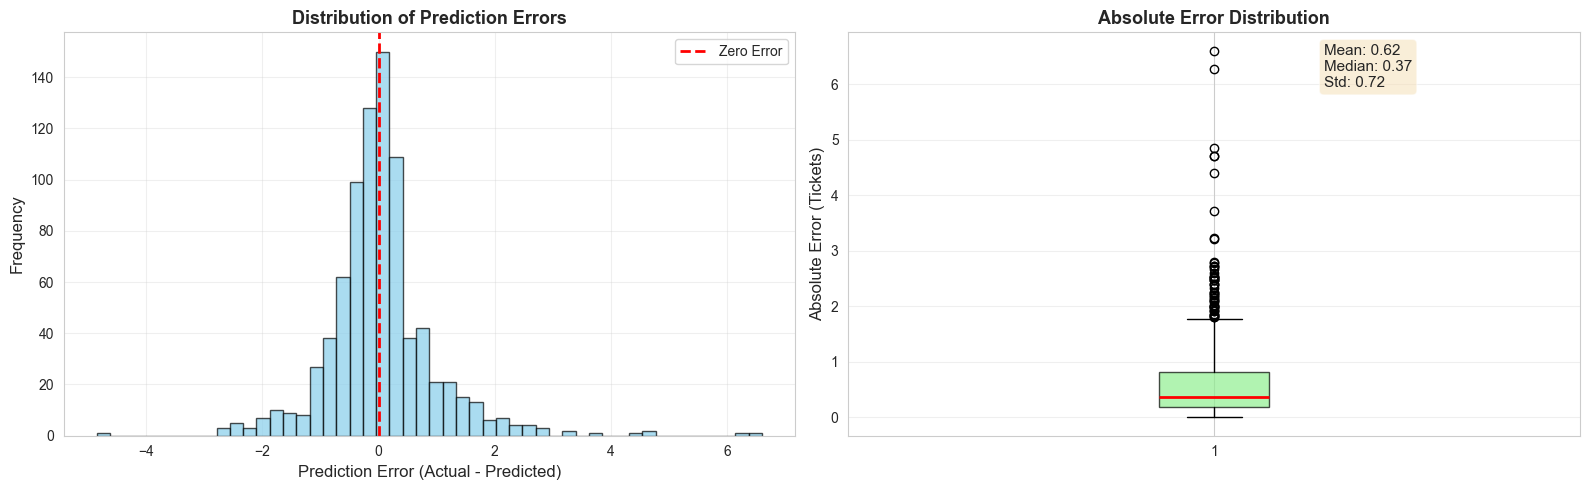

Histogram shows error distribution (should be centered at 0)
Box plot shows spread and outliers


In [10]:
# Error distribution
errors = (y_actual - y_pred).flatten()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
abs_errors = np.abs(errors)
axes[1].boxplot(abs_errors, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Absolute Error (Tickets)', fontsize=12)
axes[1].set_title('Absolute Error Distribution', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

stats_text = f"Mean: {np.mean(abs_errors):.2f}\nMedian: {np.median(abs_errors):.2f}\nStd: {np.std(abs_errors):.2f}"
axes[1].text(1.15, np.max(abs_errors)*0.9, stats_text, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("Histogram shows error distribution (should be centered at 0)")
print("Box plot shows spread and outliers")

### Visualization 4: Residual Plot

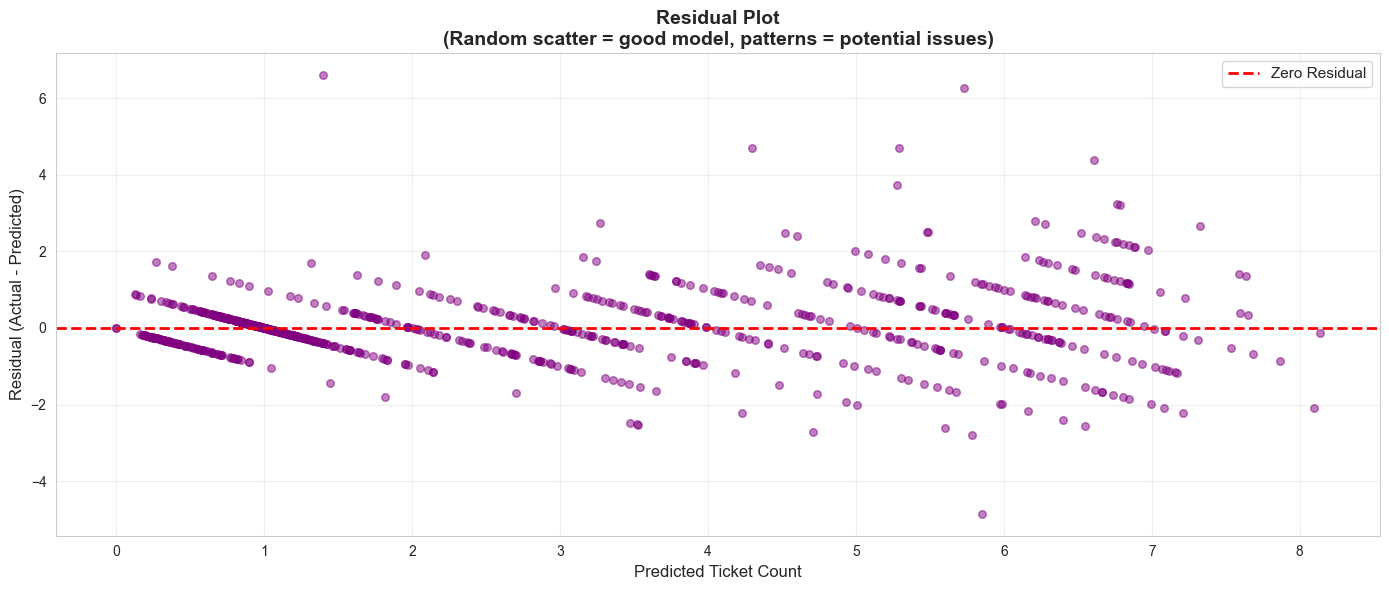

Points should scatter randomly around zero
No patterns = model assumptions are valid


In [11]:
# Residual plot
plt.figure(figsize=(14, 6))

residuals = (y_actual - y_pred).flatten()
plt.scatter(y_pred, residuals, alpha=0.5, s=30, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

plt.xlabel('Predicted Ticket Count', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot\n(Random scatter = good model, patterns = potential issues)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Points should scatter randomly around zero")
print("No patterns = model assumptions are valid")

### Model Performance Summary:
- **MAE**: Average error per prediction
- **MSE**: Penalizes larger errors more
- **RMSE**: Standard deviation of errors
- **R²**: Overall model quality (closer to 1 = better)

### Visualizations

1. **Time Series**: Shows how well model tracks actual patterns over time
2. **Scatter Plot**: Shows prediction accuracy (points near diagonal = accurate)
3. **Error Distribution**: Shows if errors are symmetric and normally distributed
4. **Residual Plot**: Checks for systematic bias or patterns in errors